In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt

In [2]:
beta =0.995
delta = 1.5
theta = 0.25
y = 1.
a_max = 8.

In [3]:
pienb = np.array([[22/23, 1/23],[0.5,0.5]], dtype=np.float64)

In [3]:
bc_tran = np.array([[0.9375, 0.0625],[0.0625,0.9375]], dtype=np.float64)
# gg gb
# bg bb
pieg = np.array([[0.975, 0.025],[0.6,0.4]], dtype=np.float64)
pieb = np.array([[145/154, 9/154],[3/7,4/7]], dtype=np.float64)
# ee eu
# ue uu

pie = np.repeat(bc_tran, 2, axis=0).repeat(2, axis=1) * np.tile(np.append(pieg, pieb, axis=1), (2, 1))
# eg - eg, eg - ug, eg - eb, eg - ub
# ug  - eg, ug - ug, ug- eb, ug - ub
# eb - eg, eb - ug
# ub - eg, ub - ug

#s1 - s1, s1 - s2 ..
#s2 - s1, s2 - s2 ...

In [4]:
v = np.ones((301,4),dtype=np.float64)
y_vec = np.tile(y * np.append(np.ones((301,1), dtype=np.float64), theta * np.ones((301,1), dtype=np.float64), axis=1), (1,2))
#only the first two columns used in non-business-cycle model

a_grid = np.linspace(0., a_max, 301)

In [5]:
c = (y_vec + a_grid.reshape(301,1)).repeat(301, axis=1).reshape(301,4,301) - a_grid.reshape(1,301).repeat(4, axis = 0).reshape(1,4,301)
c = np.clip(c, a_min=1e-10, a_max=10)
#skip negative consumption will break the vector/matrix form, making the code hard to read.
#though there should be some computational efficiency gain if the additional loops are compiled.

#in the algorithm, I make negative consumption very small to maintain the matrix form
cut = np.argmin(c, axis=2)

In [11]:
@numba.njit
def value_iter_jit(v, c, beta, delta, pie):
    n = 0
    err = 1.
    dims=pie.shape[0]
    while err > 1e-8 and n <= 4000:
        
        vn = v.copy()
        expc = pie @ np.transpose(v)
        u = c ** (1 - delta) / (1 - delta)
        temp = u + beta * expc.reshape(1, dims, 301)
        for i in range(301):
            for j in range(dims):
                v[i,j] =  np.max(temp[i,j,:])

        if n % 10 == 0:        
            err = np.max(np.abs(v - vn))
            
        n += 1
    return vn, temp

KeyError: 'gpu'

In [8]:
@numba.njit
def value_iter_jit_cut(v, c, cut, beta, delta, pie):
    n = 0
    err = 1.
    dims=pie.shape[0]
    cut=cut[:,0:dims]
    temp=np.ones((301,4,301), dtype=np.float64) * (-20000)
    while err > 1e-8 and n <= 4000:
        
        vn = v.copy()
        for k in range(301):
            for l in range(dims):
                for m in range(cut[k,l]):
                    temp[k,l,m]= beta * pie[l,:] @ np.transpose(v)[:,m] +  c[k,l,m] ** (1 - delta) / (1 - delta)
        for i in range(301):
            for j in range(dims):
                v[i,j] =  np.max(temp[i,j,0:cut[i,j]])

        if n % 10 == 0:        
            err = np.max(np.abs(v - vn))
            
        n += 1
    return vn, temp

In [20]:
vn_nb,temp = value_iter_jit(v[:,0:2], c[:,0:2], beta, delta, pienb)
plcnb = np.argmax(temp, axis=2)
#solve for the value function and then find the decision rules

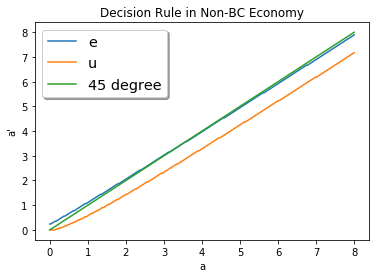

In [9]:
fig, ax = plt.subplots()
ax.plot(a_grid, plcnb[:,0]/300*a_max, label='e')
ax.plot(a_grid, plcnb[:,1]/300*a_max, label='u')
ax.plot(a_grid, a_grid, label='45 degree')
ax.set_title("Decision Rule in Non-BC Economy")
ax.set_xlabel('a')
ax.set_ylabel('a\'')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

legend.get_frame()
#fig.savefig('A1_graphs/plc_nb.png', dpi=500)
#fig.savefig('A1_graphs/plc_nb_6.png', dpi=500)
#...

In [31]:
@numba.njit
def demo_iter(demo, plc, pie):
    err = 1.
    n = 0
    dims = pie.shape[1]
    while err > 1e-10 and n <= 4000:
        demon = np.zeros((301,dims), dtype=np.float64)
        for i in range(301):
            for j in range(dims):
                aprime = plc[i,j]
                demon[aprime,:]=demo[i,j]*pie[j,:] + demon[aprime,:]
        
        if n % 5 == 0:        
            err = np.max(np.abs(demon - demo))
            
        demo = demon.copy()
        n += 1
    return demon, n

In [32]:
demo = np.ones((301,4), dtype=np.float64) / (301*4)
#only the first two columns used in non-business-cycle model

In [12]:
demo_nb, times = demo_iter(demo[:,0:2]*2, plcnb, pienb)
np.abs(demo_nb.sum()-1) < 1e-7
#sum == 1 confirmed

True

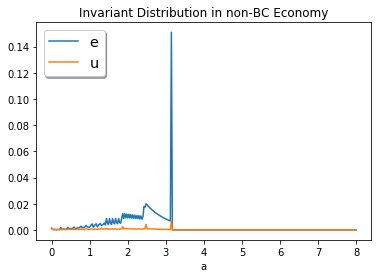

In [13]:
fig, ax = plt.subplots()
ax.plot(a_grid, demo_nb[:,0], label='e')
ax.plot(a_grid, demo_nb[:,1], label='u')
ax.set_title("Invariant Distribution in non-BC Economy")
ax.set_xlabel('a')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

legend.get_frame()
#fig.savefig('A1_graphs/dis_nb.png', dpi=500)
#fig.savefig('A1_graphs/dis_nb6.png', dpi=500)

In [14]:
np.sum(demo_nb[:,0]*a_grid/demo_nb[:,0].sum()),np.sum(demo_nb[:,1]*a_grid/demo_nb[:,1].sum())

(2.3194718727901793, 1.8463451451145838)

In [33]:
vn_b,temp = value_iter_jit(v, c, beta, delta, pie)
plcb = np.argmax(temp, axis=2)

In [35]:
demo_b, times = demo_iter(demo, plcb, pie)
np.abs(demo_b.sum()-1) < 1e-7
#sum == 1 confirmed

True

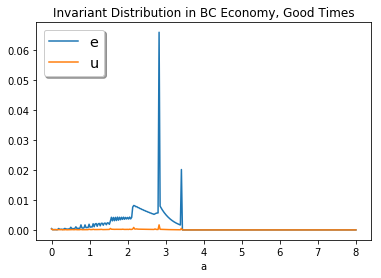

In [36]:
fig, ax = plt.subplots()
ax.plot(a_grid, demo_b[:,0], label='e')
ax.plot(a_grid, demo_b[:,1], label='u')
ax.set_title("Invariant Distribution in BC Economy, Good Times")
ax.set_xlabel('a')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

legend.get_frame()
#fig.savefig('A1_graphs/dis_b_g.png', dpi=500)
#fig.savefig('A1_graphs/dis_b_g6.png', dpi=500)

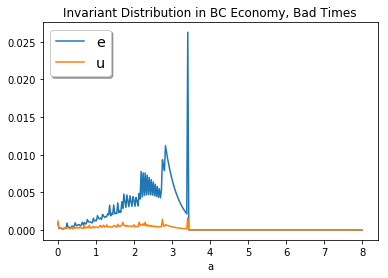

In [37]:
fig, ax = plt.subplots()
ax.plot(a_grid, demo_b[:,2], label='e')
ax.plot(a_grid, demo_b[:,3], label='u')
ax.set_title("Invariant Distribution in BC Economy, Bad Times")
ax.set_xlabel('a')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

legend.get_frame()
#fig.savefig('A1_graphs/dis_b_b.png', dpi=500)
#fig.savefig('A1_graphs/dis_b_b6.png', dpi=500)

In [19]:
np.sum((demo_b[:,0]+demo_b[:,2])*a_grid/(demo_b[:,0]+demo_b[:,2]).sum()),np.sum((demo_b[:,1]+demo_b[:,3])*a_grid/(demo_b[:,1]+demo_b[:,3]).sum())

(2.369595114729209, 1.8626909417372355)

In [73]:
np.max(demo_b, axis=0)

array([0.06598158, 0.00169184, 0.02627581, 0.00163091])

In [78]:
demo_b[128,3]

0.0016309126464959132